
<b>INSTITUTO FEDERAL DE GOIÁS<br/>
PÓS-GRADUAÇÃO EM INTELIGÊNCIA ARTIFICIAL APLICADA<br/></b>
Disciplina: Processamento de Linguagem Natural  <br/>
Professor: Daniel Xavier de Sousa <br/>
Alunos: Wagner Silva, Cleibson, Marcos Rodrigues


---

In [244]:
import pandas as pd
import numpy as np
import torch

from transformers import AutoTokenizer, AutoModel

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

In [243]:
#Dropout: 5%, 15%, 25%, 35%, and 50%
DROPOUT = 0.05

#Learning rate: 5e-4, 1e-3, 5e-3, 1e-2
LEARNING_RATE = 5e-4

In [203]:
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")
model = AutoModel.from_pretrained("xlm-roberta-base")

In [195]:
df = pd.read_csv('../datasets/buscape_preprocessed_balanced_cleared.csv')

In [196]:
df.head(3)

,review_text,rating
0,nao comparia novamente essa marca pois paguei ...,0
1,tem uma boa aderencia te da mas agilidades no ...,0
2,somente mais um jogo do estilo nada realmente ...,0


In [197]:
df.shape

(13620, 2)

In [198]:
batch_1 = df[:7500]

In [199]:
batch_1['rating'].value_counts()

rating
0    6810
1     690
Name: count, dtype: int64

In [200]:
#reviews = ["This movie was great!", "I didn't like this movie.", "Ate que gostei", "Nao achei tao legal"]
#labels = [1, 0, 1, 0]
reviews = batch_1['review_text']
labels = batch_1['rating']

#### Tokenização e geração dos embeddings
- Este processo pode demorar alguns instantes para ser concluído

In [205]:
embeddings = []
for review in reviews:
    inputs = tokenizer(review, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        output = model(**inputs)
    embeddings.append(output.last_hidden_state.mean(dim=1).numpy())

In [211]:
embeddings_array = np.vstack(embeddings)

In [240]:
print(f'{embeddings_array.shape[0]} embeddings de {embeddings_array.shape[1]} dimensões')

7500 embeddings de 768 dimensões


#### Feature based 1

In [214]:
additional_features = np.array([[len(review.split())] for review in reviews])

In [241]:
print(embeddings_array.shape)
print(additional_features.shape)

(7500, 768)
(7500, 1)


#### Combinando embeddings_array e additional_features

In [216]:
combined_features = np.hstack((embeddings_array, additional_features))

#### Dividindo dataset treino e teste

In [217]:
X_train, X_test, y_train, y_test = train_test_split(combined_features, labels, test_size=0.2, random_state=42)

In [218]:
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)

In [219]:
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)

#### Arquitetura rede neural MLP

In [239]:
model = Sequential([
    Dense(24, activation='relu', input_dim=X_train_tensor.shape[1]),
    Dropout(DROPOUT),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 24)                18480     
                                                                 
 dropout_9 (Dropout)         (None, 24)                0         
                                                                 
 dense_19 (Dense)            (None, 1)                 25        
                                                                 
Total params: 18,505
Trainable params: 18,505
Non-trainable params: 0
_________________________________________________________________


In [245]:
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=['accuracy'])

#### Cross-validation

In [246]:
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

#### Treinamento do modelo

fold = 1
Epoch 1/10
211/211 [==============================] - 1s 1ms/step - loss: 0.3673 - accuracy: 0.8824
Epoch 2/10
211/211 [==============================] - 0s 1ms/step - loss: 0.3043 - accuracy: 0.9033
Epoch 3/10
211/211 [==============================] - 0s 1ms/step - loss: 0.2793 - accuracy: 0.9030
Epoch 4/10
211/211 [==============================] - 0s 1ms/step - loss: 0.2634 - accuracy: 0.9073
Epoch 5/10
211/211 [==============================] - 0s 1ms/step - loss: 0.2542 - accuracy: 0.9098
Epoch 6/10
211/211 [==============================] - 0s 1ms/step - loss: 0.2441 - accuracy: 0.9129
Epoch 7/10
211/211 [==============================] - 0s 1ms/step - loss: 0.2366 - accuracy: 0.9120
Epoch 8/10
211/211 [==============================] - 0s 1ms/step - loss: 0.2294 - accuracy: 0.9108
Epoch 9/10
211/211 [==============================] - 0s 1ms/step - loss: 0.2255 - accuracy: 0.9119
Epoch 10/10
24/24 [==============================] - 0s 937us/step
fold = 2
Epoch 1/10
211/

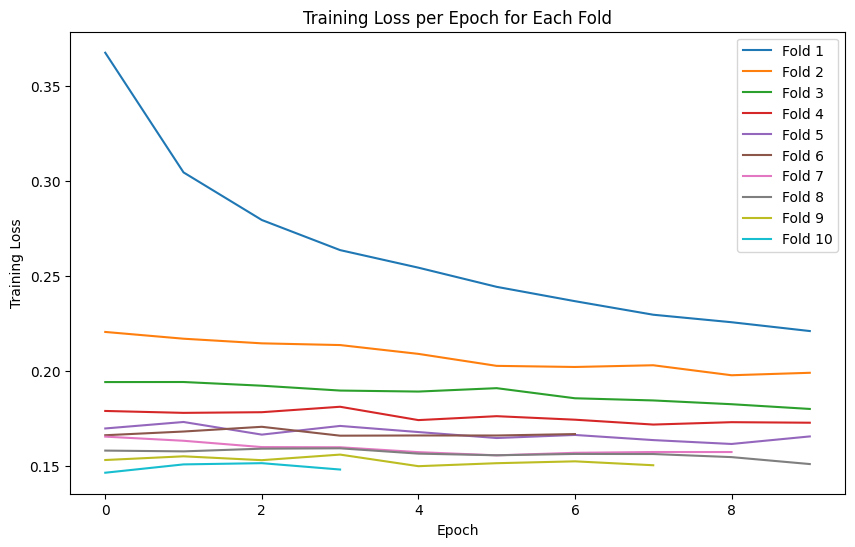

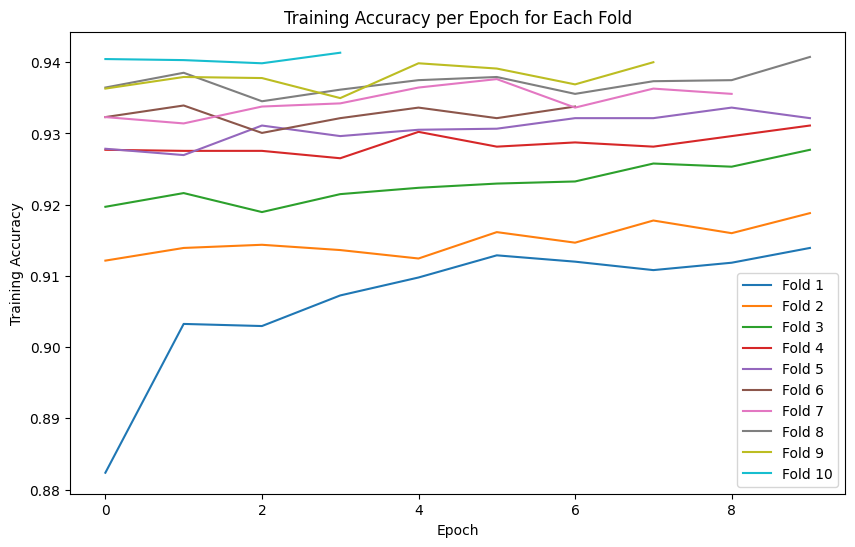

In [247]:
fold = 0

fold_accuracies = []
fold_f1_scores = []

train_loss_history = []
train_accuracy_history = []
for train_indices, val_indices in kf.split(combined_features):
    fold+=1
    print(f'fold = {fold}')
    X_train_fold = combined_features[train_indices]
    y_train_fold = np.array(labels)[train_indices]
    
    X_val_fold = combined_features[val_indices]
    y_val_fold = np.array(labels)[val_indices]
    
    X_train_fold_tensor = tf.convert_to_tensor(X_train_fold, dtype=tf.float32)
    y_train_fold_tensor = tf.convert_to_tensor(y_train_fold, dtype=tf.float32)
    X_val_fold_tensor = tf.convert_to_tensor(X_val_fold, dtype=tf.float32)
    
    model_history = model.fit(
        X_train_fold_tensor, 
        y_train_fold_tensor, 
        epochs=10, 
        batch_size=32, 
        verbose=1,
        callbacks=[EarlyStopping('loss', patience=3)],
    )
    
    y_pred_val = model.predict(X_val_fold_tensor)
    y_pred_val_binary = np.round(y_pred_val)
    
    fold_accuracy = accuracy_score(y_val_fold, y_pred_val_binary)
    fold_accuracies.append(fold_accuracy)
    
    fold_f1_score = f1_score(y_val_fold, y_pred_val_binary)
    fold_f1_scores.append(fold_f1_score)
    
    train_loss_history.append(model_history.history['loss'])
    train_accuracy_history.append(model_history.history['accuracy'])
    
print("Cross-Validation Accuracies:", fold_accuracies)
print("Cross-Validation Scores:", fold_f1_scores)
print("Media Accuracy:", np.mean(fold_accuracies))
print("Media f1 score:", np.mean(fold_f1_scores))

plt.figure(figsize=(10, 6))
for fold_num, fold_loss in enumerate(train_loss_history):
    plt.plot(fold_loss, label=f'Fold {fold_num+1}')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss per Epoch for Each Fold')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for fold_num, fold_accuracy in enumerate(train_accuracy_history):
    plt.plot(fold_accuracy, label=f'Fold {fold_num+1}')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy per Epoch for Each Fold')
plt.legend()
plt.show()

In [248]:
test_loss, test_accuracy = model.evaluate(X_test_tensor, y_test_tensor)

47/47 [==============================] - 0s 967us/step - loss: 0.1249 - accuracy: 0.9467
